In [52]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tf2onnx
import onnx

### Activating the MPS device

In [66]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("MPS device active")
    except RuntimeError as e:
        print(f"MPS device not found: {e}")

[]


### Loading and normalizing the dataset

In [ ]:
npy_folder = "smaller_dataset"  # dataset folder
classes = []
data = []
labels = []

for idx, file in enumerate(os.listdir(npy_folder)):
    if file.endswith('.npy'):
        class_name = file.split('.')[0]  # take class names from file names
        classes.append(class_name)
        file_path = os.path.join(npy_folder, file)
        class_data = np.load(file_path)
        data.append(class_data)
        labels.append(np.full(class_data.shape[0], idx))

# concatanating data and labels
data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)
data = data / 255.0  # Normalization

### Preparing train test validation splits

In [ ]:
def stratified_split(X, y, test_size, random_state=None):
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_idx, test_idx in strat_split.split(X, y):
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

# Splitting datasets 
X_temp, X_test, y_temp, y_test = stratified_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = stratified_split(X_temp, y_temp, test_size=0.25, random_state=42)  

In [ ]:
# reshaping dataset
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

### Data visualization

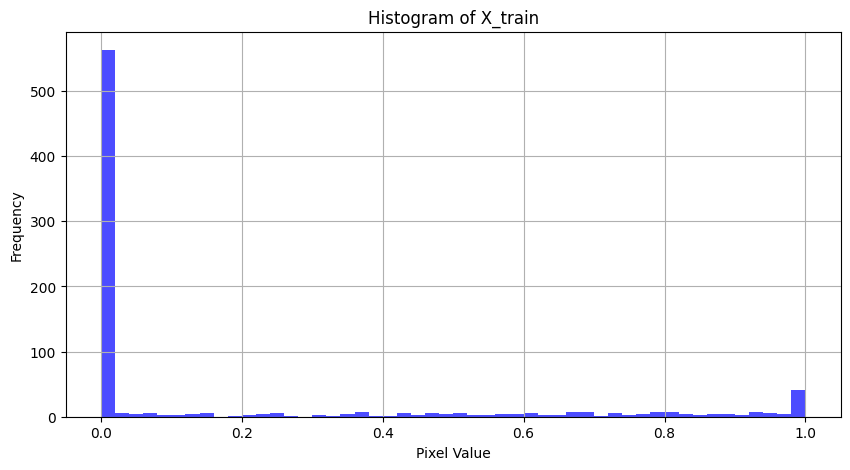

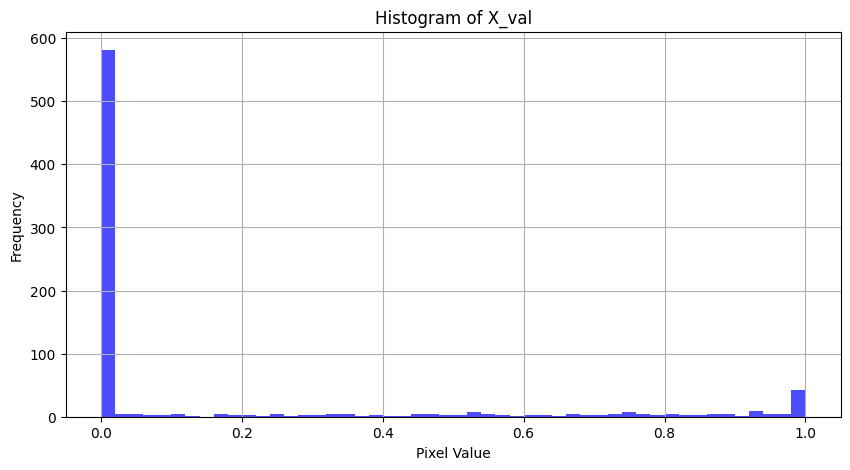

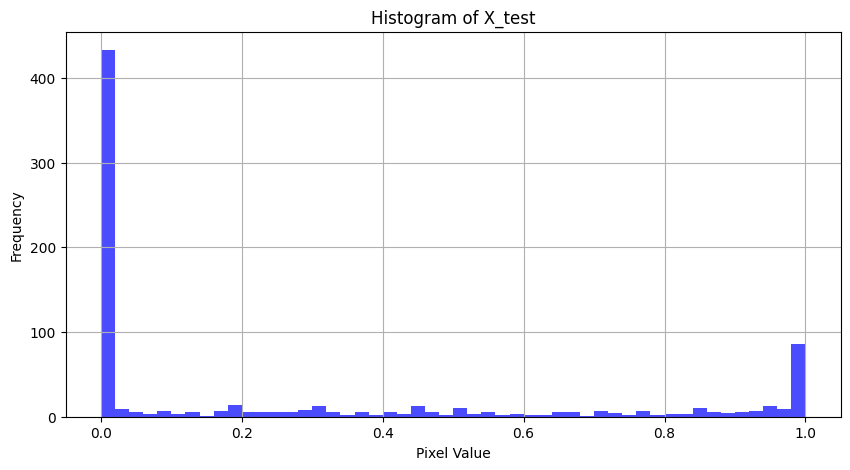

In [59]:
import matplotlib.pyplot as plt

# Histogramları çizmek için fonksiyon
def plot_histograms(data, title):
    plt.figure(figsize=(10, 5))
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f"Histogram of {title}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Histogramları çiz
plot_histograms(X_train[0], "X_train")
plot_histograms(X_val[0], "X_val")
plot_histograms(X_test[0], "X_test")


### Checking class distributions

In [60]:
# Her bir sınıfın train, val ve test setlerindeki dağılımını kontrol etmek için fonksiyon
def check_class_distribution(labels, classes):
    class_counts = {class_name: np.sum(labels == i) for i, class_name in enumerate(classes)}
    return class_counts

# Train, val ve test setlerindeki sınıf dağılımlarını kontrol et
train_distribution = check_class_distribution(y_train, classes)
val_distribution = check_class_distribution(y_val, classes)
test_distribution = check_class_distribution(y_test, classes)

print(train_distribution)
print(val_distribution)
print(test_distribution)


{'basket': np.int64(71075), 'apple': np.int64(86833), 'van': np.int64(99545), 'wine glass': np.int64(79381), 'basketball': np.int64(80275), 'axe': np.int64(74474), 'banana': np.int64(184762), 'bicycle': np.int64(75916), 'telephone': np.int64(76731), 'fork': np.int64(75646), 'cake': np.int64(74943), 'bridge': np.int64(79806), 'wristwatch': np.int64(97587), 'backpack': np.int64(75481), 'bird': np.int64(80143)}
{'basket': np.int64(23691), 'apple': np.int64(28944), 'van': np.int64(33182), 'wine glass': np.int64(26461), 'basketball': np.int64(26759), 'axe': np.int64(24824), 'banana': np.int64(61587), 'bicycle': np.int64(25306), 'telephone': np.int64(25577), 'fork': np.int64(25216), 'cake': np.int64(24981), 'bridge': np.int64(26602), 'wristwatch': np.int64(32529), 'backpack': np.int64(25160), 'bird': np.int64(26714)}
{'basket': np.int64(23692), 'apple': np.int64(28945), 'van': np.int64(33182), 'wine glass': np.int64(26460), 'basketball': np.int64(26759), 'axe': np.int64(24824), 'banana': np.

### Data visualization

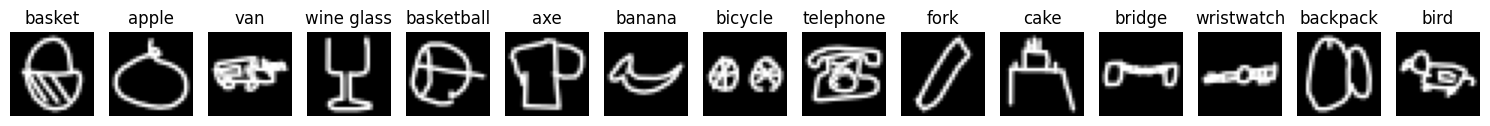

In [61]:
# Her sınıftan bir örnek gösterme
fig, axes = plt.subplots(1, len(classes), figsize=(15, 5))
for i, class_name in enumerate(classes):
    class_indices = np.where(y_train == i)[0]
    sample_image = X_train[class_indices[0]]
    axes[i].imshow(sample_image, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(class_name)
plt.tight_layout()
plt.show()

###  Model creation

In [ ]:
# Building a CNN model with three convolutional blocks.
model = models.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    
    # fully connected layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

/Users/kemalbayik/Desktop/Projects/quickdraw/quickdraw_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model compilation and training

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 424s 21ms/step - accuracy: 0.8654 - loss: 0.4729 - val_accuracy: 0.9305 - val_loss: 0.2448
Epoch 2/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 436s 21ms/step - accuracy: 0.9245 - loss: 0.2723 - val_accuracy: 0.9370 - val_loss: 0.2198
Epoch 3/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 427s 21ms/step - accuracy: 0.9309 - loss: 0.2480 - val_accuracy: 0.9405 - val_loss: 0.2088
Epoch 4/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 452s 22ms/step - accuracy: 0.9340 - loss: 0.2362 - val_accuracy: 0.9389 - val_loss: 0.2128
Epoch 5/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 461s 22ms/step - accuracy: 0.9368 - loss: 0.2266 - val_accuracy: 0.9421 - val_loss: 0.2020
Epoch 6/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 449s 22ms/step - accuracy: 0.9389 - loss: 0.2191 - val_accuracy: 0.9431 - val_loss: 0.1999
Epoch 7/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 453s 22ms/step - accuracy: 0.9398 - loss: 0.2156 - val_accuracy: 0.9438 - val_loss: 0.1972
Epoch 8/10
20510/20510 ━━━━━━━━━━━━━━━━━━━━ 457s 22ms/s

### Evaluation and saving

In [64]:
# Modelin test seti üzerindeki performansını değerlendirme
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Modeli kaydetme
model.save("quickdraw_model_15_classes.h5")

# Sınıfları kaydetme
with open("classes.txt", "w") as f:
    for class_name in classes:
        f.write(f"{class_name}\n")

13673/13673 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.9444 - loss: 0.1950


Test Loss: 0.19437216222286224
Test Accuracy: 0.9448498487472534


### Export to ONNX

In [65]:
model_path = "quickdraw_model_15_classes.h5"
model = tf.keras.models.load_model(model_path)
input_signature = [tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype, name='digit')]

model.output_names=['output']

onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature, opset=13)
onnx.save(onnx_model, "quickdraw_model_15_classes" + ".onnx")

I0000 00:00:1735614590.974099 18165383 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1735614590.974218 18165383 single_machine.cc:361] Starting new session
I0000 00:00:1735614591.085407 18165383 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1735614591.085498 18165383 single_machine.cc:361] Starting new session
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x37a08e3b0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
